In [1]:
import pandas as pd
import numpy as np
import implicit

import scipy

import catboost

from implicit.evaluation import ndcg_at_k, mean_average_precision_at_k, precision_at_k

from sklearn.model_selection import train_test_split

from sklearn.utils import shuffle

import matplotlib.pyplot as plt

import rectools

from implicit.nearest_neighbours import TFIDFRecommender, BM25Recommender
from implicit.als import AlternatingLeastSquares

from rectools import Columns
from rectools.dataset import Dataset
from rectools.metrics import Precision, Recall, MeanInvUserFreq, Serendipity, MAP, calc_metrics, MeanInvUserFreq
from rectools.models import ImplicitItemKNNWrapperModel, RandomModel, PopularModel, ImplicitALSWrapperModel, EASEModel
from rectools.model_selection import TimeRangeSplitter, cross_validate

In [2]:
interactions = pd.read_csv('interactions.csv')
interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1594787 entries, 0 to 1594786
Data columns (total 5 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   user_id        1594787 non-null  int64  
 1   item_id        1594787 non-null  int64  
 2   last_watch_dt  1594787 non-null  object 
 3   total_dur      1594786 non-null  float64
 4   watched_pct    1594519 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 60.8+ MB


In [3]:
interactions.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250.0,72.0
1,699317,1659,2021-05-29,8317.0,100.0
2,656683,7107,2021-05-09,10.0,0.0
3,864613,7638,2021-07-05,14483.0,100.0
4,964868,9506,2021-04-30,6725.0,100.0


In [4]:
users = pd.read_csv("users.csv")

In [5]:
users.head()

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0


In [6]:
items = pd.read_csv("items.csv")

In [7]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15963 entries, 0 to 15962
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   item_id       15963 non-null  int64  
 1   content_type  15963 non-null  object 
 2   title         15963 non-null  object 
 3   title_orig    11218 non-null  object 
 4   release_year  15865 non-null  float64
 5   genres        15963 non-null  object 
 6   countries     15926 non-null  object 
 7   for_kids      566 non-null    float64
 8   age_rating    15961 non-null  float64
 9   studios       1065 non-null   object 
 10  directors     14454 non-null  object 
 11  actors        13344 non-null  object 
 12  description   15961 non-null  object 
 13  keywords      15540 non-null  object 
dtypes: float64(3), int64(1), object(10)
memory usage: 1.7+ MB


In [8]:
items.head()

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж..."


In [9]:
interactions.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250.0,72.0
1,699317,1659,2021-05-29,8317.0,100.0
2,656683,7107,2021-05-09,10.0,0.0
3,864613,7638,2021-07-05,14483.0,100.0
4,964868,9506,2021-04-30,6725.0,100.0


In [10]:
interactions['user_id'].nunique()

567588

In [11]:
interactions.drop_duplicates()
interactions.dropna()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250.0,72.0
1,699317,1659,2021-05-29,8317.0,100.0
2,656683,7107,2021-05-09,10.0,0.0
3,864613,7638,2021-07-05,14483.0,100.0
4,964868,9506,2021-04-30,6725.0,100.0
...,...,...,...,...,...
1594781,890162,14006,2021-08-03,889.0,15.0
1594782,63645,16373,2021-04-20,30964.0,100.0
1594783,90242,15739,2021-07-27,12265.0,100.0
1594784,32937,10954,2021-05-13,71.0,1.0


In [12]:
interactions = interactions[interactions["watched_pct"] >= 30]

In [13]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 819338 entries, 0 to 1594783
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   user_id        819338 non-null  int64  
 1   item_id        819338 non-null  int64  
 2   last_watch_dt  819338 non-null  object 
 3   total_dur      819338 non-null  float64
 4   watched_pct    819338 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 37.5+ MB


In [14]:
interactions["weight"] = interactions["watched_pct"] / 100

In [15]:
interactions.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct,weight
0,176549,9506,2021-05-11,4250.0,72.0,0.72
1,699317,1659,2021-05-29,8317.0,100.0,1.00
3,864613,7638,2021-07-05,14483.0,100.0,1.00
4,964868,9506,2021-04-30,6725.0,100.0,1.00
5,1032142,6686,2021-05-13,11286.0,100.0,1.00


In [16]:
interactions.last_watch_dt = pd.to_datetime(interactions.last_watch_dt)

In [17]:
max_date = pd.to_datetime(interactions['last_watch_dt'].max())
min_date = pd.to_datetime(interactions['last_watch_dt'].min())

print(f"min дата в interactions: {min_date}")
print(f"max дата в interactions: {max_date}")

min дата в interactions: 2021-03-13 00:00:00
max дата в interactions: 2021-08-22 00:00:00


<Axes: xlabel='last_watch_dt'>

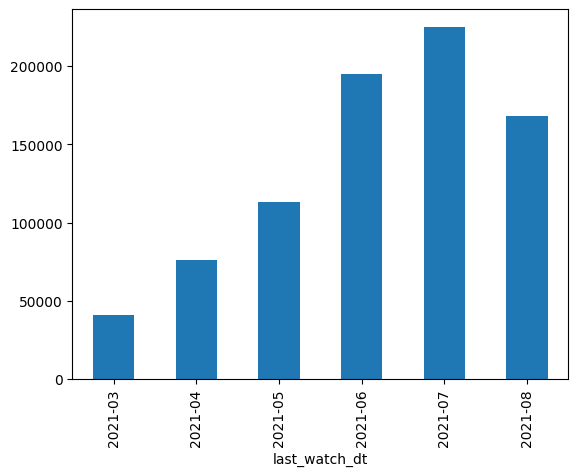

In [18]:
interactions['last_watch_dt'].dt.to_period('M').value_counts().sort_index().plot(kind='bar')

In [19]:
# Сортируем по времени
interactions_sorted = interactions.sort_values('last_watch_dt')

# Определим границу по индексу
split_index = int(0.8 * len(interactions_sorted))
cutoff_date = interactions_sorted.iloc[split_index]['last_watch_dt']

In [20]:
train = interactions[(interactions['last_watch_dt'] < cutoff_date)]
test = interactions[(interactions['last_watch_dt'] >= cutoff_date)]

print(f"train: {train.shape}")
print(f"test: {test.shape}")

train: (651116, 6)
test: (168222, 6)


In [23]:
client_mapping = {client_id: i for i, client_id in enumerate(train['user_id'].unique())}
inverse_client_mapping = {i: client_id for client_id, i in client_mapping.items()}

sku_mapping = {sku: i for i, sku in enumerate(train['item_id'].unique())}
inverse_sku_mapping = {i: sku for sku, i in sku_mapping.items()}

In [25]:
users = np.array(train['user_id'].map(client_mapping))
items = np.array(train['item_id'].map(sku_mapping))
ratings = np.array(train['weight'])

In [26]:
user_item_matrix = scipy.sparse.csr_matrix((ratings, (users, items)))

In [28]:
als = implicit.als.AlternatingLeastSquares(factors = 10, \
      iterations = 10, use_gpu = False, calculate_training_loss = False, regularization = 0.1)

als.fit(user_item_matrix)


  0%|          | 0/10 [00:00<?, ?it/s]

Альтернативный метод наименьших квадратов. Реализация рекомендателя с использованием метода альтернативных наименьших квадратов для факторизации матрицы в совместной фильтрации. В совместной фильтрации факторизация матрицы является передовым решением для проблем с разреженными данными, часто встречающихся при работе с входными данными рекомендательных систем.

In [29]:
train.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct,weight
0,176549,9506,2021-05-11,4250.0,72.0,0.72
1,699317,1659,2021-05-29,8317.0,100.0,1.00
3,864613,7638,2021-07-05,14483.0,100.0,1.00
4,964868,9506,2021-04-30,6725.0,100.0,1.00
5,1032142,6686,2021-05-13,11286.0,100.0,1.00


In [30]:
als.recommend(client_mapping[176549],
              N=10, user_items=user_item_matrix, 
              filter_already_liked_items=False)

(array([ 70, 100,  36,  61, 277,  29,  59,  71,   5, 126]),
 array([0.03827842, 0.01571187, 0.01380156, 0.01211915, 0.01123505,
        0.00764247, 0.00718728, 0.0065157 , 0.00437873, 0.00343612],
       dtype=float32))

rectools

In [32]:
interactions.rename(columns={'last_watch_dt':Columns.Datetime, 'weight':Columns.Weight}, inplace=True)

In [33]:
%%time
dataset = Dataset.construct(interactions_df=interactions)

CPU times: total: 125 ms
Wall time: 636 ms


In [57]:
# Take few simple models to compare
models = {
    "random": RandomModel(random_state=42),
    "popular": PopularModel(),
    "most_raited": PopularModel(popularity="sum_weight"),
    "tfidf_k=5": ImplicitItemKNNWrapperModel(model=TFIDFRecommender(K=5)), #Обертка для implicit.nearest_neighbours.ItemItemRecommender и его последователей.
    "tfidf_k=10": ImplicitItemKNNWrapperModel(model=TFIDFRecommender(K=10)),
    "bm25_k=10_k1=0.05_b=0.1": ImplicitItemKNNWrapperModel(model=BM25Recommender(K=5, K1=0.05, B=0.1)),
    "als" : ImplicitALSWrapperModel(AlternatingLeastSquares(factors = 10, iterations = 10, use_gpu = False, calculate_training_loss = False, regularization = 0.1)),
    "ease" : EASEModel()
}

# We will calculate several classic (precision@k and recall@k) and "beyond accuracy" metrics
metrics = {
    "prec@1": Precision(k=1),
    "prec@10": Precision(k=10),
    "recall@1": Recall(k=10),
    "recall@10": Recall(k=10),
    "novelty": MeanInvUserFreq(k=10),
    "serendipity": Serendipity(k=10)
}

K_RECS = 10

In [58]:
n_splits = 3

splitter = TimeRangeSplitter(
    test_size="7D",
    n_splits=n_splits,
    filter_already_seen=True,
    filter_cold_items=True,
    filter_cold_users=True,
)

In [59]:
%%time

# For each fold generate train and test part of dataset
# Then fit every model, generate recommendations and calculate metrics

cv_results = cross_validate(
    dataset=dataset,
    splitter=splitter,
    models=models,
    metrics=metrics,
    k=K_RECS,
    filter_viewed=True,
)

CPU times: total: 18min 27s
Wall time: 16min 24s


In [114]:
pivot_results = (
    pd.DataFrame(cv_results["metrics"])
    .drop(columns="i_split")
    .groupby(["model"], sort=False)
    .agg(["mean", "std"])
)
mean_metric_subset = [(metric, "mean") for metric in pivot_results.columns.levels[0]]
(
    pivot_results.style
    .highlight_min(subset=mean_metric_subset, color='lightcoral', axis=0)
    .highlight_max(subset=mean_metric_subset, color='lightgreen', axis=0)
)

In [115]:
random_model = RandomModel(random_state=42)

In [116]:
random_model.fit(dataset)

In [117]:
tfidf = ImplicitItemKNNWrapperModel(model=TFIDFRecommender(K=5))

In [118]:
tfidf.fit(dataset)

In [119]:
bm_model = ImplicitItemKNNWrapperModel(model=BM25Recommender(K=5, K1=0.05, B=0.1))

In [120]:
bm_model.fit(dataset)

test

In [121]:
test = test[test.user_id.isin(train.user_id.unique())]

In [122]:
random_test_recos = random_model.recommend(
    users=test.user_id.unique(),
    dataset=dataset,
    k=150,
    filter_viewed=True
)

In [123]:
random_test_recos

,user_id,item_id,score,rank
0,127724,10340,150.0,1
1,127724,4642,149.0,2
2,127724,990,148.0,3
3,127724,12147,147.0,4
4,127724,13248,146.0,5
...,...,...,...,...
5946295,545447,9883,5.0,146
5946296,545447,4063,4.0,147
5946297,545447,6726,3.0,148
5946298,545447,852,2.0,149


In [124]:
tfidf_test_recos = tfidf.recommend(
    users=test.user_id.unique(),
    dataset=dataset,
    k=150,
    filter_viewed=True
)

In [125]:
tfidf_test_recos

,user_id,item_id,score,rank
0,127724,703,0.033971,1
1,127724,5044,0.032566,2
2,127724,13217,0.032142,3
3,127724,998,0.032142,4
4,127724,14470,0.026687,5
...,...,...,...,...
800960,545447,9494,0.036289,16
800961,545447,1537,0.034668,17
800962,545447,2954,0.033313,18
800963,545447,967,0.018776,19


In [126]:
bm_test_recos = bm_model.recommend(
    users=test.user_id.unique(),
    dataset=dataset,
    k=150,
    filter_viewed=True
)

In [127]:
metrics_name = {
    'MAP': MAP,
    'Precision': Precision,
    'Recall' : Recall,
    'MIUF': MeanInvUserFreq
    

}
metrics = {}
for metric_name, metric in metrics_name.items():
    for k in (1, 5, 10):
        metrics[f'{metric_name}@{k}'] = metric(k=k)

In [128]:
two_recos = random_test_recos.merge(right=tfidf_test_recos, on = ['user_id', 'item_id'], how='inner', suffixes=['_random', '_tfidf'])
#how - как именно объединять между собой датафреймы
#можно использовать left, что отдает приоритет только колонкам левого (рандомтест) массива. 
#Тут нужен inner, который сохраняет значения между пересекающимися по названию колонками

In [129]:
two_recos

,user_id,item_id,score_random,rank_random,score_tfidf,rank_tfidf
0,514235,10440,104.0,47,0.035435,4
1,84682,7544,116.0,35,0.069520,12
2,84682,10968,1.0,150,0.041586,27
3,306633,6306,147.0,4,0.043455,47
4,619155,949,131.0,20,0.039805,8
...,...,...,...,...,...,...
11724,593260,14686,99.0,52,0.053000,4
11725,928332,4151,98.0,53,0.039844,2
11726,424623,10810,66.0,85,0.011805,10
11727,1075668,8410,120.0,31,0.018139,16


In [130]:
three_recos = two_recos.merge(bm_test_recos, on = ['user_id', 'item_id'], how='left')
three_recos = three_recos.rename(columns={'rank':'rank_bm', 'score':'score_bm'})

In [131]:
three_recos

,user_id,item_id,score_random,rank_random,score_tfidf,rank_tfidf,score_bm,rank_bm
0,514235,10440,104.0,47,0.035435,4,7234.737793,4.0
1,84682,7544,116.0,35,0.069520,12,NaN,NaN
2,84682,10968,1.0,150,0.041586,27,NaN,NaN
3,306633,6306,147.0,4,0.043455,47,NaN,NaN
4,619155,949,131.0,20,0.039805,8,NaN,NaN
...,...,...,...,...,...,...,...,...
11724,593260,14686,99.0,52,0.053000,4,NaN,NaN
11725,928332,4151,98.0,53,0.039844,2,8046.324707,2.0
11726,424623,10810,66.0,85,0.011805,10,NaN,NaN
11727,1075668,8410,120.0,31,0.018139,16,NaN,NaN


In [132]:
three_recos.fillna(0,inplace=True)

In [133]:
three_recos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11729 entries, 0 to 11728
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       11729 non-null  int64  
 1   item_id       11729 non-null  int64  
 2   score_random  11729 non-null  float32
 3   rank_random   11729 non-null  int64  
 4   score_tfidf   11729 non-null  float32
 5   rank_tfidf    11729 non-null  int64  
 6   score_bm      11729 non-null  float32
 7   rank_bm       11729 non-null  float64
dtypes: float32(3), float64(1), int64(4)
memory usage: 595.7 KB


In [134]:
three_recos['rank'] = (three_recos.rank_random + three_recos.rank_tfidf + three_recos.rank_bm) // 3
three_recos.head()

,user_id,item_id,score_random,rank_random,score_tfidf,rank_tfidf,score_bm,rank_bm,rank
0,514235,10440,104.0,47,0.035435,4,7234.737793,4.0,18.0
1,84682,7544,116.0,35,0.069520,12,0.000000,0.0,15.0
2,84682,10968,1.0,150,0.041586,27,0.000000,0.0,59.0
3,306633,6306,147.0,4,0.043455,47,0.000000,0.0,17.0
4,619155,949,131.0,20,0.039805,8,0.000000,0.0,9.0


In [135]:
three_recos['rank'] = three_recos['rank'].astype(np.int32) + 1

In [136]:
three_recos

,user_id,item_id,score_random,rank_random,score_tfidf,rank_tfidf,score_bm,rank_bm,rank
0,514235,10440,104.0,47,0.035435,4,7234.737793,4.0,19
1,84682,7544,116.0,35,0.069520,12,0.000000,0.0,16
2,84682,10968,1.0,150,0.041586,27,0.000000,0.0,60
3,306633,6306,147.0,4,0.043455,47,0.000000,0.0,18
4,619155,949,131.0,20,0.039805,8,0.000000,0.0,10
...,...,...,...,...,...,...,...,...,...
11724,593260,14686,99.0,52,0.053000,4,0.000000,0.0,19
11725,928332,4151,98.0,53,0.039844,2,8046.324707,2.0,20
11726,424623,10810,66.0,85,0.011805,10,0.000000,0.0,32
11727,1075668,8410,120.0,31,0.018139,16,0.000000,0.0,16


In [137]:
reco = three_recos[['user_id', 'item_id', 'rank']]
reco

,user_id,item_id,rank
0,514235,10440,19
1,84682,7544,16
2,84682,10968,60
3,306633,6306,18
4,619155,949,10
...,...,...,...
11724,593260,14686,19
11725,928332,4151,20
11726,424623,10810,32
11727,1075668,8410,16


In [138]:
metric_values = calc_metrics(metrics, reco, test[['user_id', 'item_id']], train[['user_id', 'item_id']], catalog=reco['item_id'])

c:\Users\Виктория\AppData\Local\Programs\Python\Python39\lib\site-packages\rectools\metrics\base.py:78: UserWarning: Expected min value of 'rank' column in 'reco' dataframe to be equal to 1.
  warnings.warn(f"Expected min value of '{Columns.Rank}' column in '{df_name}' dataframe to be equal to 1.")


In [139]:
reco = reco.sort_values(['user_id', 'rank'])


In [140]:
metric_values

{'Precision@1': 0.0,
 'Precision@5': 0.0,
 'Precision@10': 0.0,
 'Recall@1': 0.0,
 'Recall@5': 0.0,
 'Recall@10': 0.0,
 'MAP@1': 0.0,
 'MAP@5': 0.0,
 'MAP@10': 0.0,
 'MIUF@1': nan,
 'MIUF@5': 13.568886050039824,
 'MIUF@10': 14.167311662974521}

In [1]:
merged = reco.merge(test[['user_id', 'item_id']], on=['user_id', 'item_id'], how='inner')
print(f'Совпадений между reco и test: {merged.shape[0]}')


NameError: name 'reco' is not defined

In [141]:
merged = pd.merge(reco, test, on=['user_id', 'item_id'])
print(f"Совпадений между рекомендациями и тестом: {len(merged)}")


Совпадений между рекомендациями и тестом: 0


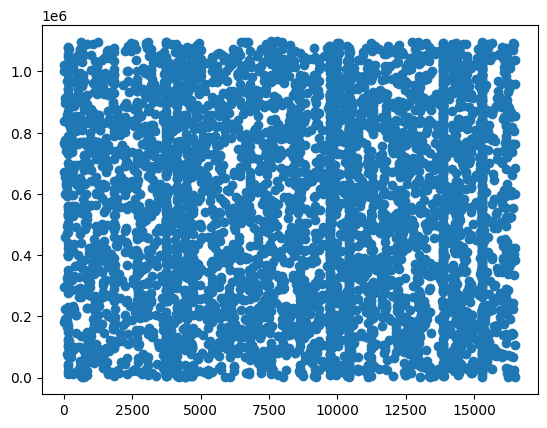

In [142]:
plt.scatter(plot_interactions.item_id, plot_interactions.user_id)